DATASET FROM http://insideairbnb.com/

In [541]:
# Install the required packages
# TODO: List of pip install commands
# 
# 
# %pip install lois
# %pip install pandas-profiling
# %pip install ipywidgets
# ...

In [542]:
# Import the required packages

#Pandas stack
import pandas as pd
import pandas_profiling
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
# Lois
from lois import lois_ds_report

# sklearn
import sklearn

import numpy as np

%matplotlib inline

In [543]:
# Load Paris airbnb data
data = pd.read_csv('../data/ParisAirbnb.csv')

In [544]:
# Remove empty column neighbourhood_group
if 'neighbourhood_group' in data.columns:
    data = data.drop('neighbourhood_group', axis=1)

# Remove the id column, since it has 100% unique values.
if 'id' in data.columns:
    data = data.drop('id', axis=1)

# These are very specific values, the neighbourhood column is more general.
if 'latitude' in data.columns and 'longitude' in data.columns:
    data = data.drop(['latitude', 'longitude'], axis=1)

# Number of reviews has a high correlation with number of reviews in the last 12 months.
# Number of reviews in the last 12 months is higly correlated with the number of reviews per month.
# Remove both columns.
if 'number_of_reviews' in data.columns and 'number_of_reviews_ltm' in data.columns:
    data = data.drop(['number_of_reviews'], axis=1)
    data = data.drop(['number_of_reviews_ltm'], axis=1)

In [545]:
# Check if the same host_id always has the same host_name
count_host_id_name_misses = 0
dic = {}
if 'host_name' in data.columns and 'host_id' in data.columns:
    for host_id, host_name in zip(data.host_id, data.host_name):
        if host_id in dic.keys():
            if dic[host_id] != host_name:
                count_host_id_name_misses += 1
                print('Host id {} has different host name {} and {}.'.format(host_id, dic[host_id], host_name))
        else:
            dic[host_id] = host_name

    print('Number of host_id that has different host_name: {}'.format(count_host_id_name_misses))

# If the ammount of host_id that has different host_name is small,
#  we can drop the host_name column. In this dataset there is only one missmatch.
# This happens because the host does not have a name (null).
#
if 'host_name' in data.columns:
    data = data.drop('host_name', axis=1)


Host id 1721954 has different host name nan and nan.
Number of host_id that has different host_name: 1


In [546]:
#
# TODO: Idea: Data mine the field name to get keywords?
#
# For now just remove the field name.
if 'name' in data.columns:
    data = data.drop('name', axis=1)


In [547]:
# Get license different values
if 'license' in data.columns:
    print(data.license.unique())
    print('Number of different license values: {}'.format(len(data.license.unique())))
    
    # Print percentage of missing values
    print('Percentage of missing values: {}'.format(data.license.isnull().sum()/len(data.license)))
    
    # There are about 40% missing values.
    # Let's drop the column and create a columns license with 0 and 1:
    #   0 if the license is missing, 1 otherwise.
    data['license'] = data['license'].apply(lambda x: 0 if pd.isnull(x) else 1)
    data.rename(columns={'license': 'has_license'}, inplace=True)

['Available with a mobility lease only ("bail mobilité")' '7510900711502'
 '7511500915333' ... '92012-BB-2017-12' '9205000010315' '9205100032915']
Number of different license values: 30789
Percentage of missing values: 0.39841929438605067


In [548]:
# 
# TODO: Idea: Some hosts have multiple listings, what does that mean?
#       If a host has 50 listings, is that correlated with a higher price?
#
# For now just remove the field host_id.
if 'host_id' in data.columns:
    data = data.drop('host_id', axis=1)

Number of unique values: 20


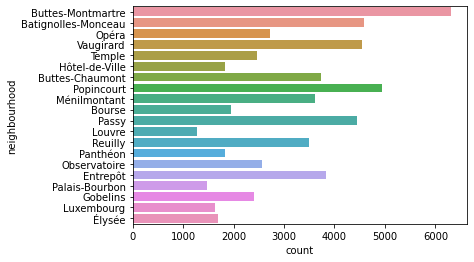

In [549]:
# TODO: Is this helpful? Or should we just remove this column?
# Handle the neighbourhood column
if 'neighbourhood' in data.columns:
    # Get unique value count
    print('Number of unique values: {}'.format(len(data.neighbourhood.unique())))
    
    # Get unique values
    unique = data.neighbourhood.unique()
    
    # Build dictionary
    neighbourhood_dict = {}
    for i, neighbourhood in enumerate(unique):
        neighbourhood_dict[neighbourhood] = i
        
    # Get neighbourhood distribution percentage
    sns.countplot(y='neighbourhood', data=data)
    
    # Encode the neighbourhood column
    data['neighbourhood'] = data['neighbourhood'].apply(lambda x: neighbourhood_dict[x])    
    
    # Rename the neighbourhood column
    data.rename(columns={'neighbourhood': 'neighbourhood_id'}, inplace=True)

Number of unique values: 4
Unique values: ['Entire home/apt' 'Private room' 'Shared room' 'Hotel room']
Entire home/apt    84.269535
Private room       13.395258
Hotel room          1.727369
Shared room         0.607838
Name: room_type, dtype: float64


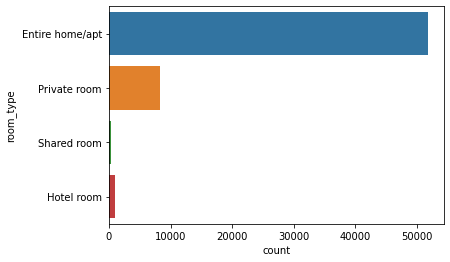

In [550]:
# Handle room_type column
if 'room_type' in data.columns:
    # Get unique value count
    print('Number of unique values: {}'.format(len(data.room_type.unique())))
    
    # Get unique values
    unique = data.room_type.unique()
    print('Unique values: {}'.format(unique))
    
    # Build dictionary
    room_type_dict = {}
    for i, room_type in enumerate(unique):
        room_type_dict[room_type] = i
    
    # Get room_type distribution
    sns.countplot(y='room_type', data=data)
    
    # Get room_type count
    print(data.room_type.value_counts()/len(data.room_type) * 100)
    
    # Distribution is:
    #  Entire home/apt : 84%
    #  Private room    : 14%
    #  Hotel room      : 1.5%
    #  Shared room     : 0.5%
    #
    # Create two categoris: Entire home/apt and not Entire home/apt
    #   Entire home/apt     : 1
    #   Not Entire home/apt : 0
    data['room_type'] = data['room_type'].apply(lambda x: 1 if x == 'Entire home/apt' else 0)
    
    # Rename the room_type column
    data.rename(columns={'room_type': 'is_entire_home'}, inplace=True)
    

/home/rubensas/anaconda3/envs/DAA/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Count of each year:
2022.0    50.664059
2019.0     7.579239
2020.0     6.031125
2021.0     4.295608
2018.0     4.104946
2017.0     3.322741
2016.0     2.868084
2015.0     1.551373
2014.0     0.182514
2013.0     0.022814
2012.0     0.011407
2011.0     0.004889
2010.0     0.001630
Name: last_review, dtype: float64
Number of missing values: 11880
Percentage of missing values: 0.1935956978733806
Count of each month from 2022:
8    45.693149
7    20.353812
9    17.963976
6     6.947572
5     3.753619
4     1.987777
1     1.418463
3     1.145063
2     0.736571
Name: last_review, dtype: float64


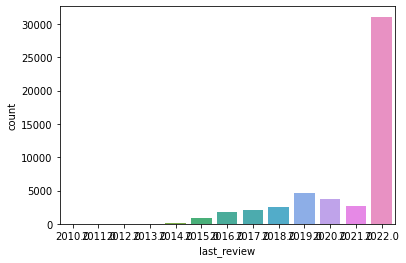

In [551]:
# Handle last_review column
#
# This is a date, we can convert it to a datetime object.
# We can see the distribution of the last_review column.
if 'last_review' in data.columns:
    dates = pd.to_datetime(data.last_review)

    years = dates.dt.year

    # Get distribution of years
    sns.countplot(years)

    # Print count of each year (in percentage)
    print("Count of each year:")
    print(years.value_counts() / len(years) * 100)

    # Print missing values count
    print('Number of missing values: {}'.format(data.last_review.isnull().sum()))
    print('Percentage of missing values: {}'.format(data.last_review.isnull().sum()/len(data.last_review)))

    # Take the 2022 year values
    this_year = dates.apply(lambda x: x if x.year == 2022 else np.nan).dropna()

    # Get month distribution count
    print("Count of each month from 2022:")
    this_year_months = this_year.dt.month
    print(this_year_months.value_counts() / len(this_year_months) * 100)

    # Create bins for:
    #   Last three months : 1
    #   This year         : 2
    #   Later             : 3
    #   Never             : 0
    #
    # Build dictionary
    data['last_review'] = data['last_review'].apply(lambda x : pd.to_datetime(x)) \
            .apply(lambda x : 0 if pd.isnull(x) else 3 if x.year < 2022 else 1 if x.month > 6 else 2)

    # Rename the last_review column
    data.rename(columns={'last_review': 'last_review_bin'}, inplace=True)

Number of missing values: 11880
Number of values smaller than 1: 31648
Number of unique values: 33
Count of each value:
1     51.573372
0     19.359570
2     14.475678
3      7.109916
4      3.731769
5      1.797442
6      0.909313
7      0.518211
8      0.247698
9      0.102664
10     0.045629
11     0.035851
13     0.019555
12     0.019555
14     0.006518
15     0.004889
20     0.003259
32     0.003259
26     0.003259
25     0.003259
24     0.003259
22     0.003259
19     0.003259
17     0.003259
16     0.003259
21     0.001630
27     0.001630
54     0.001630
18     0.001630
81     0.001630
33     0.001630
90     0.001630
61     0.001630
Name: reviews_per_month, dtype: float64


/home/rubensas/anaconda3/envs/DAA/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


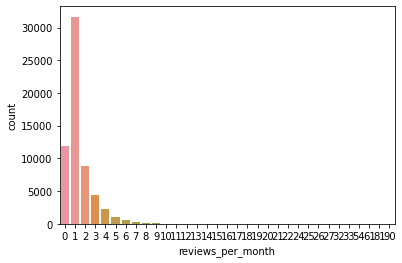

In [552]:
# Handle reviews_per_month column
if 'reviews_per_month' in data.columns:
    # Get values
    reviews_per_month = data.reviews_per_month
    
    # Get number of missing values
    print('Number of missing values: {}'.format(reviews_per_month.isnull().sum()))
        
    # Get number of values smaller than 1
    print('Number of values smaller than 1: {}'.format(len(reviews_per_month[reviews_per_month < 1])))
    
    # Parse to int: 0 if missing, otherwise int(x) + 1
    reviews_per_month = reviews_per_month.apply(lambda x : 0 if pd.isnull(x) else int(x) + 1)
    
    # Get unique value count
    print('Number of unique values: {}'.format(len(reviews_per_month.unique())))
        
    # Get count of each value
    sns.countplot(reviews_per_month)
    
    # Print count of each value
    print("Count of each value:")
    print(reviews_per_month.value_counts() / len(reviews_per_month) * 100)
    
    # Merge any value bigger than 5 to 5
    reviews_per_month = reviews_per_month.apply(lambda x : 5 if x > 5 else x)

    # Effectively we have 6 categories:
    #  0 : No reviews
    #  1 : less than one review per month
    #  2 : 1-2 review per month
    #  3 : 2-3 review per month
    #  4 : 3-4 review per month
    #  5 : 5+ review per month
    #
    # Replace the reviews_per_month column
    data['reviews_per_month'] = reviews_per_month
    
    # Rename the reviews_per_month column
    data.rename(columns={'reviews_per_month': 'reviews_per_month_bin'}, inplace=True)


Number of unique values: 92


/home/rubensas/anaconda3/envs/DAA/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Top 10 values:
Value: 365, Count: 12658 (20.63%)
Value: 2, Count: 11738 (19.13%)
Value: 1, Count: 11464 (18.68%)
Value: 3, Count: 8987 (14.65%)
Value: 4, Count: 4143 (6.75%)
Value: 30, Count: 3366 (5.49%)
Value: 5, Count: 3337 (5.44%)
Value: 7, Count: 1579 (2.57%)
Value: 6, Count: 1181 (1.92%)
Value: 10, Count: 418 (0.68%)


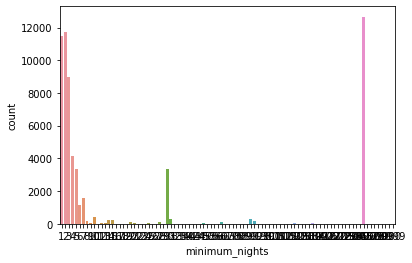

In [553]:
# Handle minimum_nights column
if 'minimum_nights' in data.columns:
    minimum_nights = data.minimum_nights
    
    # Get unique value count
    print('Number of unique values: {}'.format(len(minimum_nights.unique())))
    
    sns.countplot(minimum_nights)
    
    # Get top 10 values
    top_four = []
    print("Top 10 values:")
    for i, (value, count) in enumerate(minimum_nights.value_counts().items()):
        if i == 10:
            break
        print('Value: {}, Count: {} ({:.2f}%)'.format(value, count, count/len(minimum_nights) * 100))
        
        if i < 4:
            top_four.append(value)
    
    # Map the most common 4 values (~80% of the data), the rest to 5
    minimum_nights = minimum_nights.apply(lambda x : x if x in top_four else 5)
    
    # Replace and rename columns
    data['minimum_nights'] = minimum_nights
    data.rename(columns={'minimum_nights': 'minimum_nights_bin'}, inplace=True)
    

In [554]:
# Handle availability_365 column
if 'availability_365' in data.columns:
    
    # Print unique values
    print('Number of unique values: {}'.format(len(data.availability_365.unique())))
    
    availability_365 = data.availability_365
    
    # Get top 10 values
    print("Top 10 values:")
    for i, (value, count) in enumerate(availability_365.value_counts().items()):
        if i == 10:
            break
        print('Value: {}, Count: {} ({:.2f}%)'.format(value, count, count/len(availability_365) * 100))
    
    # Most rows have 0 availability, we can ignore this column
    data = data.drop(columns=['availability_365'])


Number of unique values: 366
Top 10 values:
Value: 0, Count: 24837 (40.47%)
Value: 365, Count: 819 (1.33%)
Value: 1, Count: 785 (1.28%)
Value: 2, Count: 546 (0.89%)
Value: 252, Count: 481 (0.78%)
Value: 364, Count: 423 (0.69%)
Value: 3, Count: 415 (0.68%)
Value: 4, Count: 384 (0.63%)
Value: 8, Count: 362 (0.59%)
Value: 251, Count: 323 (0.53%)


In [555]:
# Handle calculated_host_listings_count column
if 'calculated_host_listings_count' in data.columns:
    # Get unique value count
    print('Number of unique values: {}'.format(len(data.calculated_host_listings_count.unique())))
    
    calculated_host_listings_count = data.calculated_host_listings_count
    
    # Get top 10 values
    print("Top 3 values:")
    for i, (value, count) in enumerate(calculated_host_listings_count.value_counts().items()):
        if i == 3:
            break
        print('Value: {}, Count: {} ({:.2f}%)'.format(value, count, count/len(calculated_host_listings_count) * 100))
    
    # Bin the values to 3 categories: one listing, 2 listings, 3+ listings
    calculated_host_listings_count = calculated_host_listings_count.apply(lambda x : 1 if x == 1 else 2 if x == 2 else 3)
    
    # Replace and rename columns
    data['calculated_host_listings_count'] = calculated_host_listings_count
    data.rename(columns={'calculated_host_listings_count': 'calculated_host_listings_count_bin'}, inplace=True)
    

Number of unique values: 76
Top 3 values:
Value: 1, Count: 43127 (70.28%)
Value: 2, Count: 5016 (8.17%)
Value: 3, Count: 1578 (2.57%)


In [556]:
# pandas_profiling.ProfileReport(data)

In [557]:
# Correlation matrix
# sns.heatmap(data.corr(), annot=True, fmt='.2f')

In [558]:
# Remove columns with high correlation
if 'minimum_nights_bin' in data.columns:
    data = data.drop(columns=['minimum_nights_bin'])

# Remove neighbourhood_id column
if 'neighbourhood_id' in data.columns:
    data = data.drop(columns=['neighbourhood_id'])

# Models

## Regression

### Linear Regression

45.37790750425415
Coefficients:
                                    Coefficient
is_entire_home                         4.311311
last_review_bin                      -12.930648
reviews_per_month_bin                -11.902417
calculated_host_listings_count_bin    80.572150
has_license                           45.084458
Average price: 161.81132567424427
Error metrics:
MAE: 95.2697688769792
MSE: 72541.20637402037
RMSE: 269.3347478028418


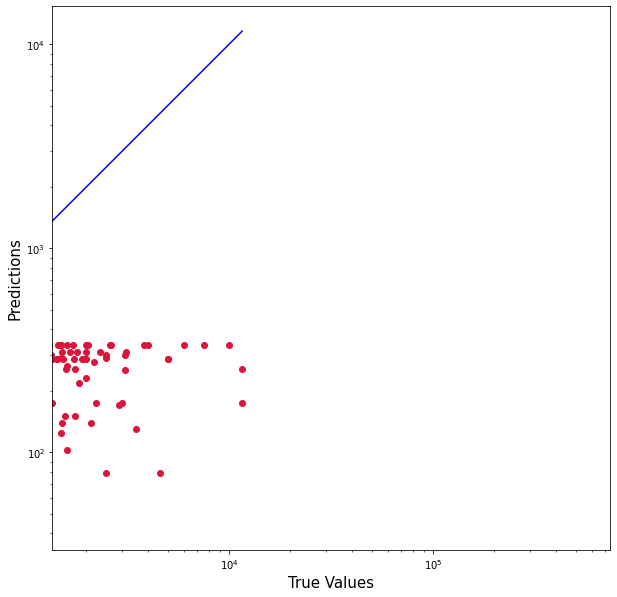

In [559]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

X = data.drop('price', axis=1)
Y = data.price

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

lm = LinearRegression()
lm.fit(X_train, Y_train)

print(lm.intercept_)
coeff_data = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient'])
print("Coefficients:")
print(coeff_data)

# Get averate price
average_price = data.price.mean()
print("Average price: {}".format(average_price))

print("Error metrics:")
predictions = lm.predict(X_test)
print('MAE:', metrics.mean_absolute_error(Y_test, predictions))
print('MSE:', metrics.mean_squared_error(Y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, predictions)))

# plot predictions vs actual
plt.figure(figsize=(10,10))
plt.scatter(Y_test, predictions, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predictions), max(Y_test))
p2 = min(min(predictions), min(Y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()


## Classification

In [560]:
data_classification = data.copy()
data_classification['price'] = pd.qcut(data_classification.price, 20, labels=False)

### Logistic Regression

In [565]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

# Logistic regression
#
X, Y = data_classification.drop('price', axis=1), data_classification.price

X = preprocessing.StandardScaler().fit(X).transform(X)

# Split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)

score = logisticRegr.score(X_test, y_test)
print(score)


0.1387598794100872


### Decision Tree Regression

In [153]:
from sklearn.tree import DecisionTreeClassifier

# Split the data into train and test sets
X, Y = data_classification.drop('price', axis=1), data_classification.price

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, Y_train)
predictions = clf.predict(X_test)
print("Accuracy: {}".format(clf.score(X_test, Y_test)))



Accuracy: 0.14348570031777072
